In [1]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.6MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 1.2MB 8.3MB/s 
     |████████████████████████████████| 194kB 15.7MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
!cp '/content/gdrive/MyDrive/Colab Notebooks/AirplanesClassifier/data/data.zip' .

In [5]:
%%capture
!unzip data.zip

In [6]:
images_path = Path('/content/data/img')

In [7]:
airplanes = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=44),
    get_y=parent_label,
    item_tfms=Resize(128)
)

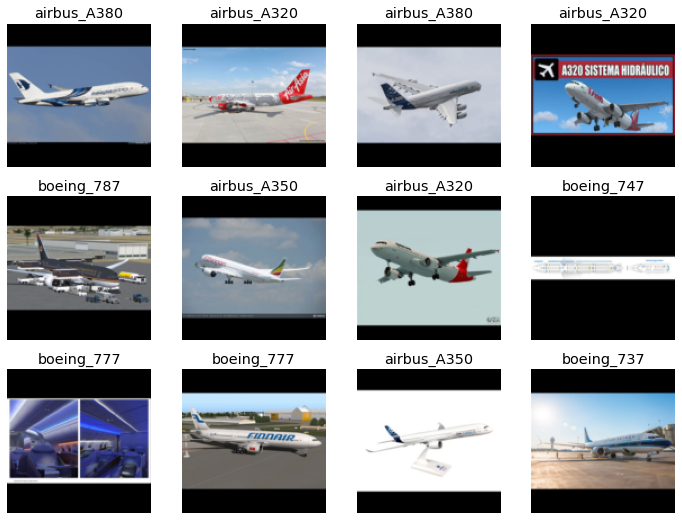

In [8]:
airplanes = airplanes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dataloaders = airplanes.dataloaders(images_path)
dataloaders.valid.show_batch(max_n=12, nrows=3)

## Remove non-plane photos with use of pretrained model (we want only the airliners)

In [9]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-02-10 12:26:41--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-02-10 12:26:42 (50.4 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [10]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [11]:
categories[:4]

['tench', 'goldfish', 'great white shark', 'tiger shark']

In [12]:
categories.index('airliner')

404

In [13]:
%%capture
import torchvision.models as models
resnet50_pure = models.resnet50(pretrained=True)

In [14]:
# prepare example images
from torchvision import transforms

input_image_interior = Image.open('/content/data/img/boeing_747/28c4931db7464e9aacb7073c58e0df34.jpg')
input_image_plane = Image.open('/content/data/img/boeing_747/001f3ef01dc042dbae2eac1caeb2d0ea.jpg')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor_plane = preprocess(input_image_plane)
input_tensor_interior = preprocess(input_image_interior)

In [15]:
resnet50_pure.eval()
with torch.no_grad():
    out_data_plane = resnet50_pure(input_tensor_plane.unsqueeze(0))
    out_data_interior = resnet50_pure(input_tensor_interior.unsqueeze(0))

In [16]:
# Plane image
torch.argmax(out_data_plane), categories[torch.argmax(out_data_plane)]

(tensor(404), 'airliner')

In [17]:
# Interior image
torch.argmax(out_data_interior), categories[torch.argmax(out_data_interior)]

(tensor(762), 'restaurant')

In [18]:
# Probabilities for interior
probabilities = torch.nn.functional.softmax(out_data_interior[0], dim=0)
probabilities[404], probabilities[466]

(tensor(0.0017), tensor(0.0055))

## Filtering out photos without airliners

In [19]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2021-02-10 12:26:46--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2021-02-10 12:26:46 (78.8 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [20]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [21]:
categories.index('airliner')

404

In [22]:
%%capture
import torchvision.models as models
resnet50_pure = models.resnet50(pretrained=True)

In [23]:
# input_image_interior = Image.open('/content/data/img/boeing_747/28c4931db7464e9aacb7073c58e0df34.jpg')
# input_image_plane = Image.open('/content/data/img/boeing_747/001f3ef01dc042dbae2eac1caeb2d0ea.jpg')
preprocess_for_prediction = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
!mkdir categories_temp

In [25]:
resnet50_pure.eval()
df = pd.DataFrame()
save_interval = 1000
predicted_categories = []
paths_to_files = []
with torch.no_grad():
  # not elegant and efficient, maybe load and process in batches
  for index, img_path in enumerate(get_image_files(images_path)):
    img_temp = Image.open(img_path)
    # print(img_path)
    img_tensor = preprocess_for_prediction(img_temp)
    prediction = resnet50_pure(img_tensor.unsqueeze(0))
    # print((torch.argmax(prediction), categories[torch.argmax(prediction)]))
    predicted_categories.append(categories[torch.argmax(prediction)])
    paths_to_files.append(img_path)
    if index % save_interval == save_interval - 1:
      df_temp = pd.DataFrame.from_dict({'file': paths_to_files, 'category': predicted_categories})
      df = pd.concat([df, df_temp], ignore_index=True)
      df_temp.to_csv(Path('./categories_temp')/f"categories_{index}.csv", index=False)
      predicted_categories = []
      paths_to_files = []
df_temp = pd.DataFrame.from_dict({'file': paths_to_files, 'category': predicted_categories})
df_temp.to_csv(Path('./categories_temp')/f"categories_last.csv", index=False)
df = pd.concat([df, df_temp], ignore_index=True)
df.to_csv('categories_final.csv', index=False)

In [34]:
# df = pd.DataFrame()
# for csv_path in Path('./categories_temp').ls():
#   df_temp = pd.read_csv(csv_path)
#   df = pd.concat([df, df_temp], ignore_index=True)

In [35]:
len(get_image_files(images_path)), len(df)

(8814, 8814)

In [37]:
# df.to_csv('categories_final.csv', index=False)

In [38]:
# !cp categories_final.csv '/content/gdrive/MyDrive/Colab Notebooks/AirplanesClassifier/data/'